<a href="https://colab.research.google.com/github/griffinfulton-uark/Classification-Model-Project-/blob/main/Classificationmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# BERT classification Model 

In [2]:
!pip install snscrape
!pip install transformers
!pip install lime
!pip install textblob
!pip install XGBoost

     |████████████████████████████████| 4.0 MB 5.4 MB/s 
     |████████████████████████████████| 77 kB 6.6 MB/s 
     |████████████████████████████████| 6.6 MB 38.2 MB/s 
     |████████████████████████████████| 596 kB 42.6 MB/s 
     |████████████████████████████████| 880 kB 44.7 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=959415fbc743e590dc5272fdd074cba48935f219abbb9f59e122e315abb923d6
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 275 kB 5.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=c7e3accf2dd5aa44d8d75acf4fccde3d0911165d156d2548a5600f9e36c9ab20
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701

In [3]:
## for data
import textblob
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
from lime import lime_text
## for word embedding
from textblob import TextBlob
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers
import xgboost as xgb
from xgboost import XGBClassifier
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Add labels for the tweets
We take the tweets and label them as 1 for republican and 0 for democratic. The labels must be binary for the model to work properly.

In [6]:
# read platform tweets
platform_tweets = pd.read_csv('/content/drive/MyDrive/EconomicAnalyticsFinalProject/platform_tweets.csv')
def get_party(x):
  if x == 'GOP' or x == 'GOPChairwoman':
    return 1
  else: 
    return 0

def get_party_2(x):
  if x == 'GOP':
    return 1
  else: 
    return 0
platform_tweets['OutcomeVar'] = platform_tweets['User'].apply(lambda x: get_party(x))
#platform_tweets.sample(10)

In [7]:
### so theres an issue here, i have a training and validation set, but I need to test it on a seperate set as the model is tuning based on the validation set
### gonna split up the data frame into two different data frames based on the outcome variable (party)


Rep_set = platform_tweets[platform_tweets.OutcomeVar == 1]
Dem_set = platform_tweets[platform_tweets.OutcomeVar == 0]
print(len(Rep_set)*.7)
print(len(Rep_set)*.3)

print(len(Dem_set)*.7)
print(len(Dem_set)*.3)

rep_train_len = 4316
rep_test_len = 1850

dem_train_len = 4726
dem_test_len = 2026

## new numners when not including these other homies

## now we need to create new data sets for each of these and and combine the data frames for them

reptrainingset = Rep_set.iloc[:rep_train_len]
demtrainingset = Dem_set.iloc[:dem_train_len]
reptestset = Rep_set.iloc[rep_train_len:]
demtestset = Dem_set.iloc[dem_train_len:]

## now I am going to combine the test/training set for repubs and dems
trainingset = pd.concat([reptrainingset, demtrainingset], axis=0)
testset = pd.concat([reptestset, demtestset], axis=0)


trainingset
testset

4316.2
1849.8
4726.4
2025.6


,Unnamed: 0,Date,User,Tweets,handle,Party,OutcomeVar
4316,1231,2021-10-11 11:29:00+00:00,GOPChairwoman,Remember when Biden cancelled the Keystone pip...,"['GOP', 'R']","['GOPChairwoman', 'R']",1
4317,1232,2021-10-10 23:07:00+00:00,GOPChairwoman,Democrat Terry McAuliffe keeps attacking paren...,"['GOP', 'R']","['GOPChairwoman', 'R']",1
4318,1233,2021-10-10 19:23:00+00:00,GOPChairwoman,Biden is still insisting his socialist agenda ...,"['GOP', 'R']","['GOPChairwoman', 'R']",1
4319,1234,2021-10-10 15:08:49+00:00,GOPChairwoman,Biden wants to turn the IRS into a spy agency ...,"['GOP', 'R']","['GOPChairwoman', 'R']",1
4320,1235,2021-10-10 12:57:00+00:00,GOPChairwoman,Biden bragged that his reckless tax-and-spendi...,"['GOP', 'R']","['GOPChairwoman', 'R']",1
...,...,...,...,...,...,...,...
12913,3185,2021-01-03 13:31:58+00:00,harrisonjaime,"In the end, folks like @MittRomney will have t...","['GOP', 'R']","['GOPChairwoman', 'R']",0
12914,3186,2021-01-03 13:31:58+00:00,harrisonjaime,We should all be disgusted by the treachery of...,"['GOP', 'R']","['GOPChairwoman', 'R']",0
12915,3187,2021-01-03 13:31:58+00:00,harrisonjaime,"Lindsey was right, we may be witnessing the de...","['GOP', 'R']","['GOPChairwoman', 'R']",0
12916,3188,2021-01-03 01:50:42+00:00,harrisonjaime,A must read thread from my friend @SteveSchmid...,"['GOP', 'R']","['GOPChairwoman', 'R']",0


## Now  that we have cleaned up ths structure of the data, we want to set up the GPU for the model. We ran this model on google Collab. 

In [8]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [9]:
import tensorflow as tf
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [10]:
trainingset = trainingset.sample(frac=1).reset_index(drop=True)
sentences = trainingset.Tweets.values
labels = trainingset.OutcomeVar.values



In [11]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
sentences

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

array(["President Biden has:\n➡️ Directed vital humanitarian and security aid to Ukraine \n➡️ United our allies across the globe against Putin's aggression\n➡️ Issued crippling sanctions towards Russia\n\nHe continues to lead our country, and the world, to stand with Ukraine.",
       'The world is watching. Will we be able to say we protected American democracy and passed meaningful voting rights legislation? \nhttps://t.co/fiDu8r6U3e',
       'The red state recovery is real.\n \nRepublican states are bringing back jobs faster than blue states.',
       ...,
       "Congressional Republicans stood in the way of getting checks in pockets and more shots in arms. \n\nWe're running ads to make sure voters don't forget it: https://t.co/dHQLvIZrkO",
       'In the words of my grandma, “just hush.” You broke the Senate when you schemed &amp; lied to deny Obama a SCt justice &amp; then shoehorned one in days before the 20 presidential election.\n\nDid lightening strike the unfortunate soul wh

In [12]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  President Biden has:
➡️ Directed vital humanitarian and security aid to Ukraine 
➡️ United our allies across the globe against Putin's aggression
➡️ Issued crippling sanctions towards Russia

He continues to lead our country, and the world, to stand with Ukraine.
Tokenized:  ['president', 'bid', '##en', 'has', ':', '[UNK]', 'directed', 'vital', 'humanitarian', 'and', 'security', 'aid', 'to', 'ukraine', '[UNK]', 'united', 'our', 'allies', 'across', 'the', 'globe', 'against', 'putin', "'", 's', 'aggression', '[UNK]', 'issued', 'cr', '##ip', '##pling', 'sanctions', 'towards', 'russia', 'he', 'continues', 'to', 'lead', 'our', 'country', ',', 'and', 'the', 'world', ',', 'to', 'stand', 'with', 'ukraine', '.']
Token IDs:  [2343, 7226, 2368, 2038, 1024, 100, 2856, 8995, 11470, 1998, 3036, 4681, 2000, 5924, 100, 2142, 2256, 6956, 2408, 1996, 7595, 2114, 22072, 1005, 1055, 14974, 100, 3843, 13675, 11514, 14353, 17147, 2875, 3607, 2002, 4247, 2000, 2599, 2256, 2406, 1010, 1998, 1996, 

In [13]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  121


In [14]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  President Biden has:
➡️ Directed vital humanitarian and security aid to Ukraine 
➡️ United our allies across the globe against Putin's aggression
➡️ Issued crippling sanctions towards Russia

He continues to lead our country, and the world, to stand with Ukraine.
Token IDs: tensor([  101,  2343,  7226,  2368,  2038,  1024,   100,  2856,  8995, 11470,
         1998,  3036,  4681,  2000,  5924,   100,  2142,  2256,  6956,  2408,
         1996,  7595,  2114, 22072,  1005,  1055, 14974,   100,  3843, 13675,
        11514, 14353, 17147,  2875,  3607,  2002,  4247,  2000,  2599,  2256,
         2406,  1010,  1998,  1996,  2088,  1010,  2000,  3233,  2007,  5924,
         1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [15]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

8,137 training samples
  905 validation samples


In [16]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [17]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [18]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [19]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [20]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [21]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

## Training the BERT model after preprocessing all of the tweets. The data has been split into a training and validation set. 

In [22]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    255.    Elapsed: 0:00:26.
  Batch    80  of    255.    Elapsed: 0:00:53.
  Batch   120  of    255.    Elapsed: 0:01:19.
  Batch   160  of    255.    Elapsed: 0:01:46.
  Batch   200  of    255.    Elapsed: 0:02:12.
  Batch   240  of    255.    Elapsed: 0:02:38.

  Average training loss: 0.30
  Training epcoh took: 0:02:48

Running Validation...
  Accuracy: 0.93
  Validation Loss: 0.17
  Validation took: 0:00:06

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    255.    Elapsed: 0:00:26.
  Batch    80  of    255.    Elapsed: 0:00:53.
  Batch   120  of    255.    Elapsed: 0:01:19.
  Batch   160  of    255.    Elapsed: 0:01:46.
  Batch   200  of    255.    Elapsed: 0:02:12.
  Batch   240  of    255.    Elapsed: 0:02:39.

  Average training loss: 0.10
  Training epcoh took: 0:02:48

Running Validation...
  Accuracy: 0.96
  Validation Loss: 0.12
  Validation took: 0:00:06

======== Epoch 3 / 4 ========
Training...
 

In [23]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.30,0.17,0.93,0:02:48,0:00:06
2,0.10,0.12,0.96,0:02:48,0:00:06
3,0.04,0.18,0.95,0:02:47,0:00:06
4,0.02,0.17,0.96,0:02:47,0:00:06


## Interpretation of results

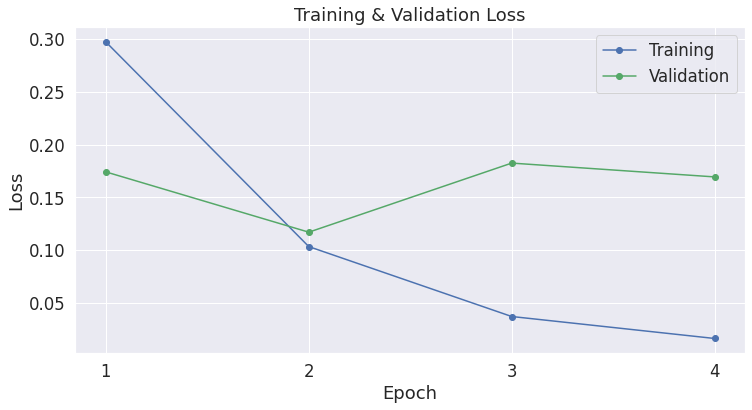

In [24]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## After training the model, we would like to test it on the test set. We have previously split the model into these two sets.



In [25]:
import pandas as pd

# Load the dataset into a pandas dataframe.

# Report the number of sentences.


# Create sentence and label lists
sentences = testset.Tweets.values
labels = testset.OutcomeVar.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [26]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 3,876 test sentences...
    DONE.


In [27]:
from sklearn.metrics import accuracy_score
#score = accuracy_score(iris.target, pr)

from sklearn.metrics import matthews_corrcoef

finalset = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = accuracy_score#(true_labels[i], pred_labels_i)                
  finalset.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [28]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
acc = accuracy_score(flat_true_labels, flat_predictions)

print('Total Acc: %.3f' % acc)

Total Acc: 0.923


(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

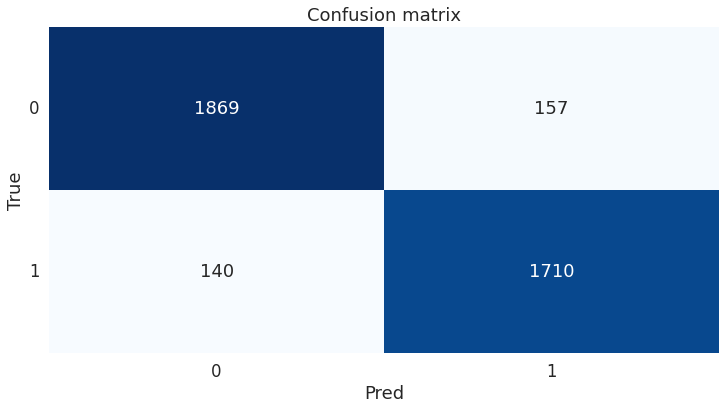

In [29]:
from sklearn.metrics import confusion_matrix


classes = np.unique(flat_true_labels)
## Plot confusion matrix
cm = confusion_matrix(flat_true_labels, flat_predictions)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

## Now that we have the model, we would like to deploy it on the twitter accounts of every senator.

In [30]:
##Now lets get the misclassification rates for the senators
## need to load in the senator tweets nows
senators = pd.read_csv('/content/drive/MyDrive/EconomicAnalyticsFinalProject/tweet_collection_v4.csv')
senators.head()

,Unnamed: 0,Date,User,Tweets,State,Party,Name
0,0,2022-04-18 21:04:16+00:00,SenShelby,Each Congress I introduce legislation that wou...,Alabama,R,"Shelby, Richard"
1,1,2022-04-17 14:29:00+00:00,SenShelby,"My wife, Annette, and I wish everyone a happy ...",Alabama,R,"Shelby, Richard"
2,2,2022-04-07 18:33:24+00:00,SenShelby,Today I voted against the confirmation of Judg...,Alabama,R,"Shelby, Richard"
3,3,2022-04-06 18:12:19+00:00,SenShelby,.@UofAlabama received a competitive $360M @NOA...,Alabama,R,"Shelby, Richard"
4,4,2022-04-06 17:11:04+00:00,SenShelby,A lot of great things happening in several of ...,Alabama,R,"Shelby, Richard"


In [31]:

# read platform tweets
# made a new function for this because the binary specification is slightly different 
def get_party_2(x):
  if x == 'R':
    return 1
  else: 
    return 0
senators['binary_party'] = senators['Party'].apply(lambda x: get_party_2(x))


In [32]:
# Create sentence and label lists
sentences = senators.Tweets.values
labels = senators.binary_party.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [33]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 137,096 test sentences...
    DONE.


In [34]:
from sklearn.metrics import accuracy_score
#score = accuracy_score(iris.target, pr)

from sklearn.metrics import matthews_corrcoef

finalset = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = accuracy_score#(true_labels[i], pred_labels_i)                
  finalset.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [35]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
acc = accuracy_score(flat_true_labels, flat_predictions)

print('Total Acc: %.3f' % acc)

Total Acc: 0.646


(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

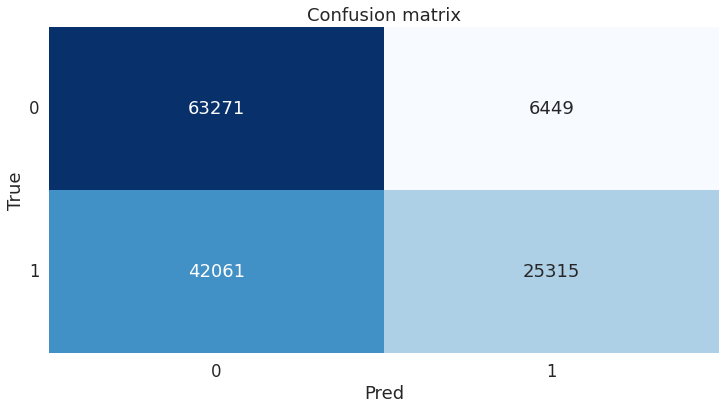

In [36]:
classes = np.unique(flat_true_labels)
## Plot confusion matrix
cm = confusion_matrix(flat_true_labels, flat_predictions)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

## Now that we have the predictions for the senators, we would like to see the accuracy for the individual senators as an accuracy rate. 

In [37]:
senators = pd.read_csv('/content/drive/MyDrive/EconomicAnalyticsFinalProject/tweet_collection_v4.csv')

senators['prediction'] = flat_predictions.tolist()
senators.head()

,Unnamed: 0,Date,User,Tweets,State,Party,Name,prediction
0,0,2022-04-18 21:04:16+00:00,SenShelby,Each Congress I introduce legislation that wou...,Alabama,R,"Shelby, Richard",0
1,1,2022-04-17 14:29:00+00:00,SenShelby,"My wife, Annette, and I wish everyone a happy ...",Alabama,R,"Shelby, Richard",1
2,2,2022-04-07 18:33:24+00:00,SenShelby,Today I voted against the confirmation of Judg...,Alabama,R,"Shelby, Richard",0
3,3,2022-04-06 18:12:19+00:00,SenShelby,.@UofAlabama received a competitive $360M @NOA...,Alabama,R,"Shelby, Richard",0
4,4,2022-04-06 17:11:04+00:00,SenShelby,A lot of great things happening in several of ...,Alabama,R,"Shelby, Richard",0


In [38]:
senators['binary_party'] = senators['Party'].apply(lambda x: get_party_2(x))

senators['Match'] = senators.binary_party.eq(senators.prediction)
sen_rate = senators.groupby('Name').Match.mean().mul(100).round(2)
#sen_rate = sen_rate.to_frame()
#senators.merge(sen_rate, on='Name', how='left', indicator=True)


In [39]:
sen_rate_df = pd.DataFrame(sen_rate)

In [40]:
sen_rate_df.shape
sen_rate_df.sample(10)

,Match
Name,
"Ossoff, Jon",81.42
"Johnson, Ron",47.95
"Whitehouse, Sheldon",69.39
"Cornyn, John",56.34
"Wyden, Ron",95.62
"Sullivan, Dan",26.03
"Paul, Rand",45.25
"Kaine, Tim",85.76
"Brown, Sherrod",91.26


## Finally, we concert the dataframe to a CSV file to do regression analysis in the Regression.ipynb file

In [41]:
sen_rate_df.to_csv('/content/drive/MyDrive/EconomicAnalyticsFinalProject/sen_rate_2.csv')

# References 
For BERT, I mainly used the youtube tutorial and Jupyternotebook. fron Chris McCormick. 
https://www.youtube.com/watch?v=_eSGWNqKeeY&t=1242s
